In [1]:
# install pygame
# pip install pygame

# install ple
# git clone https://github.com/ntasfi/PyGame-Learning-Environment.git
# cd PyGame-Learning-Environment/
# pip install -e .

# install gym_ple
# pip install gym_ple


In [2]:
%matplotlib inline
from Utils import Environment, Memory
import os
 
import matplotlib
from matplotlib.pyplot import imshow, show
from collections import deque
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import warnings
warnings.filterwarnings('ignore')
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.__version__

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


'0.4.1'

In [3]:
env = Environment()
env.action_space, env.observation_space

WARN: Environment '<class 'gym_ple.ple_env.PLEEnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.


(2, Box(512, 288, 3))

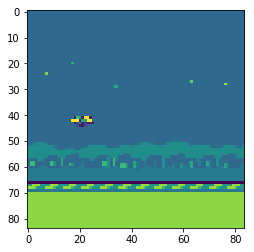

In [4]:
env.init()
env.step(1)
imshow(env.get_screen())

In [103]:
class DQRN(nn.Module):
    def __init__(self):
        super(DQRN, self).__init__()
        self.hidden_size = 128
        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(input_size=49, hidden_size=self.hidden_size, num_layers=1)
        
        self.fc1 = nn.Sequential(
            nn.Linear(8192, 512),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(512, 2)
    
    def forward(self, x, hidden_state, cell_state):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), x.size(1), -1) # (32, 64, 7, 7) -> (32, 64, 49)
        x, (next_hidden_state, next_cell_state) = self.lstm(x, (hidden_state, cell_state))
        x = x.view(x.size(0), -1) # (32, 64, 128) -> (32, 8192)
        x = self.fc1(x.view(x.size(0), -1))
        x = self.fc2(x)
        return x , next_hidden_state, next_cell_state
    
    def init_states(self):
        hidden_state = torch.zeros(1, 64, self.hidden_size, device=device)
        cell_state = torch.zeros(1, 64, self.hidden_size, device=device)
        return hidden_state, cell_state
    
    def reset_states(self, hidden_state, cell_state):
        hidden_state[:, :, :] = 0
        cell_state[:, :, :] = 0
        return hidden_state.detach(), cell_state.detach()

In [104]:
dqrn = DQRN()
(h,c) = dqrn.init_states()
x = torch.randn(32,4,84,84)
# dqrn(x,h,c)

In [111]:
class Agent(object):
    def __init__(self):
        self.env = Environment()
        self.dqn = DQRN().to(device)
        self.target = DQRN().to(device)
        self.target.load_state_dict(self.dqn.state_dict())
        self.target.eval()
        
        # For Optimization
        self.dqn_hidden_state, self.dqn_cell_state = self.dqn.init_states()
        self.target_hidden_state, self.target_cell_state = self.dqn.init_states()

        # For Training Play
        self.train_hidden_state, self.train_cell_state = self.dqn.init_states()

        # For Validation Play
        self.test_hidden_state, self.test_cell_state = self.dqn.init_states()

        self.target_update_interval = 1000
#         self.optimizer = optim.RMSprop(self.dqn.parameters())
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=0.0001)
        
        #play params
        self.play_interval = 1000
        self.play_repeat = 1
        self.best_steps_done = 0
        self.best_score = -1000
        
        self.seed = 111
        self.gamma = 0.99
        self.epsilon_start = 1.0
        self.epsilon_decay = 100000
        self.epsilon_stop = 0.01
        self.batch_size = 32
#         self.max_step = 1000
        self.global_steps = 0
        
        self.memory = Memory(50000, batch_size=self.batch_size)

        self.frame_skipping = 4
        self.state_buffer_size = 4
        self.state_buffer = deque(maxlen=self.state_buffer_size)
        
    def save_checkpoint(self, filename='checkpoints/checkpoint.pth'):
        dirpath = os.path.dirname(filename)

        if not os.path.exists(dirpath):
            os.mkdir(dirpath)

        checkpoint = {
            'dqn': self.dqn.state_dict(),
            'target': self.target.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'global_steps': self.global_steps,
            'best_score': self.best_score,
            'best_steps_done': self.best_steps_done
        }
        torch.save(checkpoint, filename)
        
    def load_checkpoint(self, filename='checkpoints/checkpoint.pth'):
        checkpoint = torch.load(filename, map_location=device.type)
        self.dqn.load_state_dict(checkpoint['dqn'])
        self.target.load_state_dict(checkpoint['target'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.global_steps = checkpoint['global_steps']
        self.best_score = checkpoint['best_score']
        self.best_steps_done = checkpoint['best_steps_done']
        
        
    def play(self, human=True):
        self.test_hidden_state, self.test_cell_state = self.dqn.reset_states(self.test_hidden_state,
                                                                     self.test_cell_state)
        
        self.env.reset()
        state = self.get_initial_state()
        steps_done = 0
        total_score = 0
        
        while True:

            state = torch.FloatTensor([state]).to(device)
            
            self.dqn.eval()
            
            dqn_pred, self.dqn_hidden_state, self.dqn_cell_state = self.dqn(state, self.test_hidden_state, self.test_cell_state)
            action = dqn_pred.cpu().max(1)[1]
            
            for _ in range(self.frame_skipping):
                if human:
                    screen = self.env.game.render(mode='human')
                _, reward, done, _ = self.env.step(action)

                next_state = self.env.get_screen()
                self.state_buffer.append(next_state)
                state = np.array(self.state_buffer)

                total_score += reward

                if done:
                    break

            steps_done += 1
            
            if done:
                self.dqn.train()
                break
        self.env.game.close()
        return total_score, steps_done

    def get_initial_state(self):
        self.env.reset()
        state = self.env.get_screen()
        
        self.state_buffer = deque(maxlen=self.state_buffer_size)
        [self.state_buffer.append(state) for _ in range(self.state_buffer_size)]
        return np.array(self.state_buffer)
    
    def optimize(self):
        self.dqn_hidden_state, self.dqn_cell_state = self.dqn.reset_states(self.dqn_hidden_state,
                                                                           self.dqn_cell_state)
        self.target_hidden_state, self.target_cell_state = self.dqn.reset_states(self.target_hidden_state,
                                                                                     self.target_cell_state)
        
        transitions = self.memory.sample()

        states = torch.cat(transitions.state).to(device)
        actions = torch.cat(transitions.action).to(device)
        rewards = torch.cat(transitions.reward).to(device)
        
        non_final_mask = torch.tensor(list(map(lambda s: s is not None, transitions.next_state)), 
                                      device=device, dtype=torch.uint8)
        non_final_next_states = torch.cat([s for s in transitions.next_state
                                            if s is not None])
        
        states = states.view([self.batch_size, self.state_buffer_size, self.env.width, self.env.height])
        q_pred, self.dqn_hidden_state, self.dqn_cell_state = self.dqn(states, self.dqn_hidden_state, self.dqn_cell_state)
        q_values = q_pred.gather(1, actions)
        
        target_values = torch.zeros(self.batch_size, device=device)
        non_final_next_states = non_final_next_states.view([-1, self.state_buffer_size, self.env.width, self.env.height]).to(device)
        target_pred, self.target_hidden_state, self.target_cell_state = self.target(non_final_next_states,
                                                                            self.target_hidden_state,
                                                                            self.target_cell_state)
        target_values[non_final_mask] = target_pred.max(1)[0].detach()
        
        rewards.data.clamp_(-1, 1)
        
        expected_state_action_values = (target_values * self.gamma) + rewards
        
        loss = F.smooth_l1_loss(q_values, expected_state_action_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.dqn.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
        
        reward_score = int(torch.sum(rewards).cpu().detach().numpy())
        
        return loss.cpu().detach().numpy(), reward_score


    def action(self, state):
        eps = self.epsilon_stop + (self.epsilon_start - self.epsilon_stop) * np.exp(-self.global_steps/self.epsilon_decay)
        if np.random.uniform() <= eps:
            state = torch.FloatTensor([state]).to(device)
            with torch.no_grad():
                action, self.dqn_hidden_state, self.dqn_cell_state = self.dqn(state, self.train_hidden_state, self.train_cell_state)
                action = action.max(1)[1].view(-1,1).cpu()
                return action, eps
        else:
            sample_action = self.env.game.action_space.sample()
            action = torch.LongTensor([[sample_action]])
            return action, eps
        
    def train(self):
        
        while True:
            self.train_hidden_state, self.train_cell_state = self.dqn.reset_states(self.train_hidden_state,
                                                                       self.train_cell_state)
            
            self.env.reset()
            state = self.get_initial_state()
            
            losses = []
            rewards = []
            steps_done = 0
            eps = self.epsilon_start
            
            done = False
            while not done:
                action, e = self.action(state)
                eps = e
                
                for _ in range(self.frame_skipping):
                    _, reward, done, _ = self.env.step(action.item())
                    next_state = self.env.get_screen()
                    self.state_buffer.append(next_state)
                    
                    if done:
                        break
            
            
                next_state = np.array(self.state_buffer)
                
                if done:
                    self.memory.add(state, action, reward, None)
                else:
                    self.memory.add(state, action, reward, next_state)

                state = next_state
                
                if self.memory.is_ready():
                    l, r = self.optimize()
                    losses.append(l)
                    rewards.append(r)

                steps_done += 1
                self.global_steps += 1
                
                # update target network
                if self.global_steps % self.target_update_interval == 0:
                    print('update target network!')
                    self.target.load_state_dict(self.dqn.state_dict())
              
                # Play
                if self.global_steps % self.play_interval == 0:
                    scores = []
                    total_steps_done = []
                    for _ in range(self.play_repeat):
                        score, steps_done = self.play(human=True)
                        scores.append(score)
                        total_steps_done.append(steps_done)
                        
                    real_score = int(np.mean(scores))
                    real_steps_done = int(np.mean(total_steps_done))

                    if self.best_steps_done <= real_steps_done:
                        self.best_score = real_score
                        self.best_steps_done = real_steps_done

                        self.save_checkpoint(
                            filename=f'dqn_checkpoints/chkpoint_{self.best_steps_done}_{self.best_score}.pth')

            if not np.isnan(np.mean(losses)):
                print('global_steps:%d, episode_steps:%d, loss:%.6f, rewards:%d, eps:%.6f'%(self.global_steps, steps_done, np.mean(losses), np.mean(rewards), eps))
                    

In [113]:
# training
agent = Agent() 
agent.train()

global_steps:45, episode_steps:13, loss:0.020992, rewards:-1, eps:0.999564
global_steps:61, episode_steps:16, loss:0.012663, rewards:-1, eps:0.999406
global_steps:77, episode_steps:16, loss:0.008840, rewards:-1, eps:0.999248
global_steps:93, episode_steps:16, loss:0.004432, rewards:-1, eps:0.999090
global_steps:109, episode_steps:16, loss:0.004154, rewards:-2, eps:0.998931
global_steps:125, episode_steps:16, loss:0.002543, rewards:-1, eps:0.998773
global_steps:141, episode_steps:16, loss:0.001811, rewards:-1, eps:0.998615
global_steps:157, episode_steps:16, loss:0.001102, rewards:-1, eps:0.998457
global_steps:173, episode_steps:16, loss:0.001340, rewards:-1, eps:0.998299
global_steps:189, episode_steps:16, loss:0.001356, rewards:-1, eps:0.998141
global_steps:205, episode_steps:16, loss:0.000803, rewards:-1, eps:0.997982
global_steps:221, episode_steps:16, loss:0.000857, rewards:-2, eps:0.997824
global_steps:237, episode_steps:16, loss:0.000541, rewards:-1, eps:0.997666
global_steps:253

global_steps:1771, episode_steps:16, loss:0.000707, rewards:-1, eps:0.982631
global_steps:1787, episode_steps:16, loss:0.001513, rewards:-1, eps:0.982476
global_steps:1803, episode_steps:16, loss:0.002116, rewards:-1, eps:0.982320
global_steps:1819, episode_steps:16, loss:0.001492, rewards:-2, eps:0.982164
global_steps:1835, episode_steps:16, loss:0.001039, rewards:-1, eps:0.982009
global_steps:1860, episode_steps:25, loss:0.000893, rewards:-1, eps:0.981766
global_steps:1876, episode_steps:16, loss:0.000535, rewards:-1, eps:0.981610
global_steps:1892, episode_steps:16, loss:0.001821, rewards:-2, eps:0.981455
global_steps:1908, episode_steps:16, loss:0.000856, rewards:-2, eps:0.981300
global_steps:1924, episode_steps:16, loss:0.000462, rewards:-2, eps:0.981144
global_steps:1940, episode_steps:16, loss:0.002171, rewards:-1, eps:0.980989
global_steps:1956, episode_steps:16, loss:0.000663, rewards:-1, eps:0.980833
global_steps:1972, episode_steps:16, loss:0.000467, rewards:-1, eps:0.980678

KeyboardInterrupt: 

In [10]:
# agent.save_checkpoint('dqn_checkpoints/exp_01.pth')

In [13]:
# play
# agent = Agent()
# agent.load_checkpoint('dqn_checkpoints/exp_01.pth')
# agent.play(human=True)

(14.0, 194)

In [ ]:
# references
# https://github.com/AndersonJo/dqn-pytorch/blob/master/dqn.py